# Spotify Popularity Prediction Model




___

**Author**: Oun Nuqul

**Contact**: oun.nuqul@gmail.com

**Date**: April 11th 2023

____

## Table of Contents

1. Introducing this Notebook
2. Logistic Regression
    - Gridsearch
    - Best Model
    - Separate Model for Hip-hop, Acoustic, Metal, and Reggae
3. RandomForest
    - Gridsearches
    - Best Model
4. XGBoost
    - Gridsearches
    - Best Model
5. Conclusion to this Notebook

___

## Introducing this Notebook

In this notebook we will begin fitting classification models using the dataset we have cleaned and preprocessed in the last notebook. We will optimize the hyperparameters of all of these models in order to improve results as well as combat overfitting. This will be done through the use of gridsearches.

In [1]:
import pandas as pd #importing pandas
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing matplotlib
import pickle #importing pickle

from sklearn.model_selection import train_test_split #importing train_test_split
from sklearn.preprocessing import StandardScaler #importing scaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix #importing confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score #importing metric scoring functions
from sklearn.linear_model import LogisticRegression #importing LogisticRegression
from sklearn.ensemble import RandomForestClassifier #importing RandomForest
from xgboost import XGBClassifier #importing XGBoost
from sklearn.pipeline import Pipeline #importing pipelines
from sklearn.model_selection import GridSearchCV #importing gridsearches

In [2]:
#loading the data using pickle as reading .csv file was losing certain categorical values
with open('Data/df_for_modeling.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
#sanity check
df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,track_genre,preview_url,danceability,...,summer,swedish,synth-pop,tango,techno,trance,trip-hop,turkish,work-out,world-music
0,5CZ40GBx1sQ9agT82CLQCT,Olivia Rodrigo,SOUR,traitor,1,229226,0,acoustic,None,0.380,...,0,0,0,0,0,0,0,0,0,0
1,03V5hhD1z7CD41Dy4ZVthN,JJ Heller,Even Here,Even Here,0,248253,0,acoustic,https://p.scdn.co/mp3-preview/19209115f0aa0b92...,0.349,...,0,0,0,0,0,0,0,0,0,0
2,20aW5uLdlOuleBQ5RTcSQb,Casey Breves,I'll Sing to You,I'll Sing to You,0,242173,0,acoustic,https://p.scdn.co/mp3-preview/e7eda7988fbdecfd...,0.489,...,0,0,0,0,0,0,0,0,0,0
3,66iAV4LVKYYoxVeYoC8M3s,Hayd,I Fall Apart,I Fall Apart,1,240000,0,acoustic,https://p.scdn.co/mp3-preview/ad4cba4f08444f52...,0.634,...,0,0,0,0,0,0,0,0,0,0
4,0oCAVym9c3xbXmeFHN6nUR,Front Porch Step,Aware,Lullaby,0,168250,0,acoustic,https://p.scdn.co/mp3-preview/a0b9af0c08a6b332...,0.542,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60434 entries, 0 to 60433
Columns: 147 entries, track_id to world-music
dtypes: float64(11), int64(130), object(6)
memory usage: 67.8+ MB


In [5]:
#splitting into remainder and test set
df_remainder, df_test = train_test_split(df, test_size=0.25, random_state=42,
                                         stratify=df[['track_genre','popularity']])

### Logistic Regression 

The first model we are fitting is the age old linear classifier model LogisticRegression. It is unlikely that this model will yield good results, but it's worth exploring how the model will deal with the data in different circumstances. Once the gridsearch is finalized, we will use those hyperparameters in four smaller models that specifically fit to a single genre.

### Gridsearch

In [6]:
#dropping the columns that introduce multicollinearity and object type columns 
df_logit = df_remainder.drop(columns=['loudness','acousticness','instrumentalness','valence',
                            'track_id', 'artists', 'album_name', 'track_name', 'track_genre','preview_url'])

In [7]:
#splitting into X and y
X_rem = df_logit.drop(columns='popularity')
y_rem = df_logit['popularity']

Here is the first and only gridsearch for LogisticRegression. It's the only one as this model is fairly simple one with only two hyperparameters worth optimizing. The Solver, and the C value.

In [8]:
# estimator
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(max_iter=10000))
])

# parameters
params = {
    'logit__solver': ['lbfgs' ,'sag', 'saga'],
    'logit__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=2)
grid.fit(X_rem, y_rem)
    
#writting to pickle
with open('Gridsearches/LogisticRegression/Logit_grid_1.pkl', "wb") as f:
    pickle.dump(grid, f)

In [9]:
#the best parameters the gridsearch found
grid.best_params_

{'logit__C': 0.2, 'logit__solver': 'lbfgs'}

In [10]:
#the best score the gridsearch found
grid.best_score_

0.6096414782129068

In [11]:
#the top hyperparameter combinations for this model
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logit__C,param_logit__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,0.473584,0.056069,0.035544,0.004709,0.2,lbfgs,"{'logit__C': 0.2, 'logit__solver': 'lbfgs'}",0.59636,0.618423,0.613017,0.609928,0.61048,0.609641,0.007290,1
4,4.502686,0.431744,0.035738,0.005091,0.2,sag,"{'logit__C': 0.2, 'logit__solver': 'sag'}",0.59636,0.618423,0.613017,0.609928,0.61048,0.609641,0.007290,1
5,2.566851,0.210620,0.033403,0.001869,0.2,saga,"{'logit__C': 0.2, 'logit__solver': 'saga'}",0.59636,0.618423,0.613017,0.609928,0.61048,0.609641,0.007290,1
7,4.733896,0.138351,0.041050,0.006975,0.3,sag,"{'logit__C': 0.3, 'logit__solver': 'sag'}",0.59636,0.618423,0.613017,0.609928,0.61048,0.609641,0.007290,1
14,2.883290,0.190846,0.037874,0.004555,0.5,saga,"{'logit__C': 0.5, 'logit__solver': 'saga'}",0.59636,0.618312,0.613017,0.609928,0.61048,0.609619,0.007263,5


The best model for LogisticRegression uses the 'lbfgs' solver with a C value for 0.2 to regularize the fitting as to deal with potential overfitting.

### Best Model

Now to fit that model on its own so that we can explore the coefficients and find out which features are the heavies influences on the model.

In [12]:
#scaling
scaler = StandardScaler()
X_rem_ss = scaler.fit_transform(X_rem)

#fitting the final logit model
Logit_final = LogisticRegression(C=0.2, max_iter=10000).fit(X_rem_ss,y_rem)

In [13]:
#creating dataframe for coefs of logit model
Logit_final_coefs = pd.DataFrame({'Feature':list(X_rem.columns), 'Coef':list(Logit_final.coef_.reshape(-1))})
Logit_final_coefs = Logit_final_coefs.sort_values(by='Coef', ascending=False)

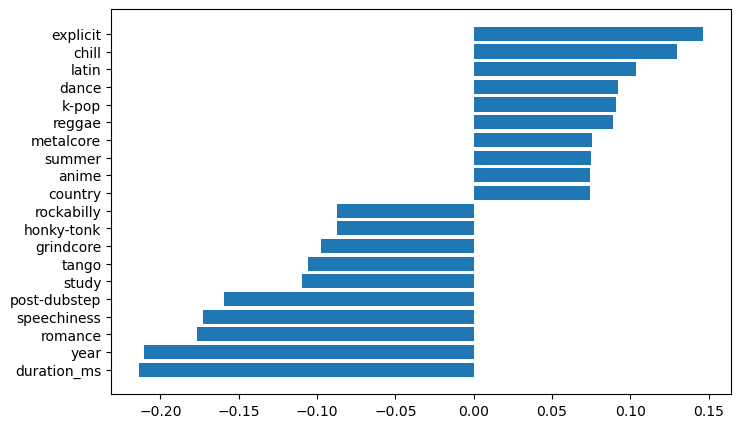

In [14]:
#plotting top coefs
plt.figure(figsize=(8,5))
plt.barh(Logit_final_coefs.tail(10).sort_values(by='Coef')['Feature'],
         Logit_final_coefs.tail(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.barh(Logit_final_coefs.head(10).sort_values(by='Coef')['Feature'],
         Logit_final_coefs.head(10).sort_values(by='Coef')['Coef'], color='#1f77b4')

plt.show()

We can see from the plot that `explicit`, `chill`, `dance`, `k-pop`, `reggae`, `metalcore`, `summer`, and `anime` have the highest positive effects on the model. Meaning that tracks that embody these features more are more likely to be popular. Adversely, we see that `country`, `rockabilly`, `honky-tonk`, `grindcore`, `tango`, `study`, `post-dubstep`, `speechiness`, `romance`, `year`, and `duration_ms`have the highest negative effects on the model. This means that tracks that embody these features more are more likely to be not-popular.

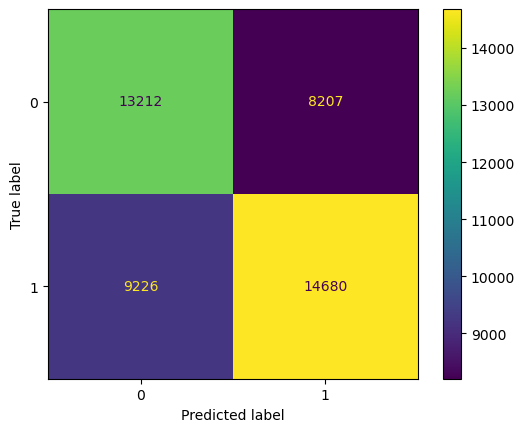

In [15]:
y_pred = Logit_final.predict(X_rem_ss)
ConfusionMatrixDisplay(confusion_matrix(y_pred,y_rem)).plot()

In [16]:
print('Accuarcy Score: ',accuracy_score(y_pred,y_rem))
print('recall Score: ',recall_score(y_pred,y_rem))
print('f1 Score: ',f1_score(y_pred,y_rem))
print('precision Score: ',precision_score(y_pred,y_rem))

Accuarcy Score:  0.6153778268063982
recall Score:  0.6140717811428094
f1 Score:  0.6274442758532259
precision Score:  0.6414121553720452


Overall, the performance of the general logisticregression model isn't the best, which is as expected. Accuracy is at 61% with recall at 61%, f1-score at 63% and precision at 64%. This means that the model misclassifies a huge chunk of the data as false not-popular and false popular predictions.

### Separate Model for Hip-hop, Acoustic, Metal, and Reggae

Now to create separate logit models for the four genres hip-hop, acoustic, metal, and reggae.

In [17]:
df_logit_genres = df_remainder.drop(columns=['loudness','acousticness','instrumentalness','valence',
                            'track_id', 'artists', 'album_name', 'track_name','preview_url'])

In [18]:
#dropping countvectorized genre features
for gen in df['track_genre'].unique():
    df_logit_genres.drop(columns=gen, inplace=True)

In [19]:
#looping over each desired genre and storing the model, coefs, and scores.
genres = ['hip-hop', 'acoustic', 'metal', 'reggae']

logit_models = {'genre':[],'model':[],'Coefs':[], 'train_score':[],'validation_score':[]}
for gen in genres:
    df_temp = df_logit_genres[df_logit_genres['track_genre'] == gen].copy().drop(columns='track_genre')
    
    #spliting while stratifying 
    df_train, df_validation = train_test_split(df_temp, test_size=0.3, random_state=42,
                                         stratify=df_temp['popularity'])
    
    #splitting into X and y
    X_train = df_train.drop(columns='popularity')
    y_train = df_train['popularity']
    
    X_val = df_validation.drop(columns='popularity')
    y_val = df_validation['popularity']
    
    scaler = StandardScaler()
    X_train_ss = scaler.fit_transform(X_train)
    X_val_ss = scaler.transform(X_val)
    
    logit_temp = LogisticRegression(C=0.2, max_iter=10000).fit(X_train_ss,y_train)
    
    logit_models['genre'].append(gen)
    logit_models['model'].append(logit_temp)
    logit_models['Coefs'].append(logit_temp.coef_)
    
    y_pred_train = logit_temp.predict(X_train_ss)
    logit_models['train_score'].append(accuracy_score(y_pred_train,y_train))
    
    y_pred_val = logit_temp.predict(X_val_ss)
    logit_models['validation_score'].append(accuracy_score(y_pred_val,y_val))

In [20]:
#organizing the new models coefs and scores into seperate dataframes
genre_logit_scores = pd.DataFrame({'genre':logit_models['genre'], 'train_score':logit_models['train_score'],
                                   'validation_score':logit_models['validation_score']})

hiphop_coefs = pd.DataFrame({'Coef': list(logit_models['Coefs'][0].reshape(-1)),
                             'Feature': list(X_train.columns)}).sort_values(by='Coef',ascending=False)
acoustic_coefs = pd.DataFrame({'Coef': list(logit_models['Coefs'][1].reshape(-1)),
                             'Feature': list(X_train.columns)}).sort_values(by='Coef',ascending=False)
metal_coefs = pd.DataFrame({'Coef': list(logit_models['Coefs'][2].reshape(-1)),
                             'Feature': list(X_train.columns)}).sort_values(by='Coef',ascending=False)
reggae_coefs = pd.DataFrame({'Coef': list(logit_models['Coefs'][3].reshape(-1)),
                             'Feature': list(X_train.columns)}).sort_values(by='Coef',ascending=False)

Text(0.5, 1.0, 'Reggae Genre Top 10 Coefs')

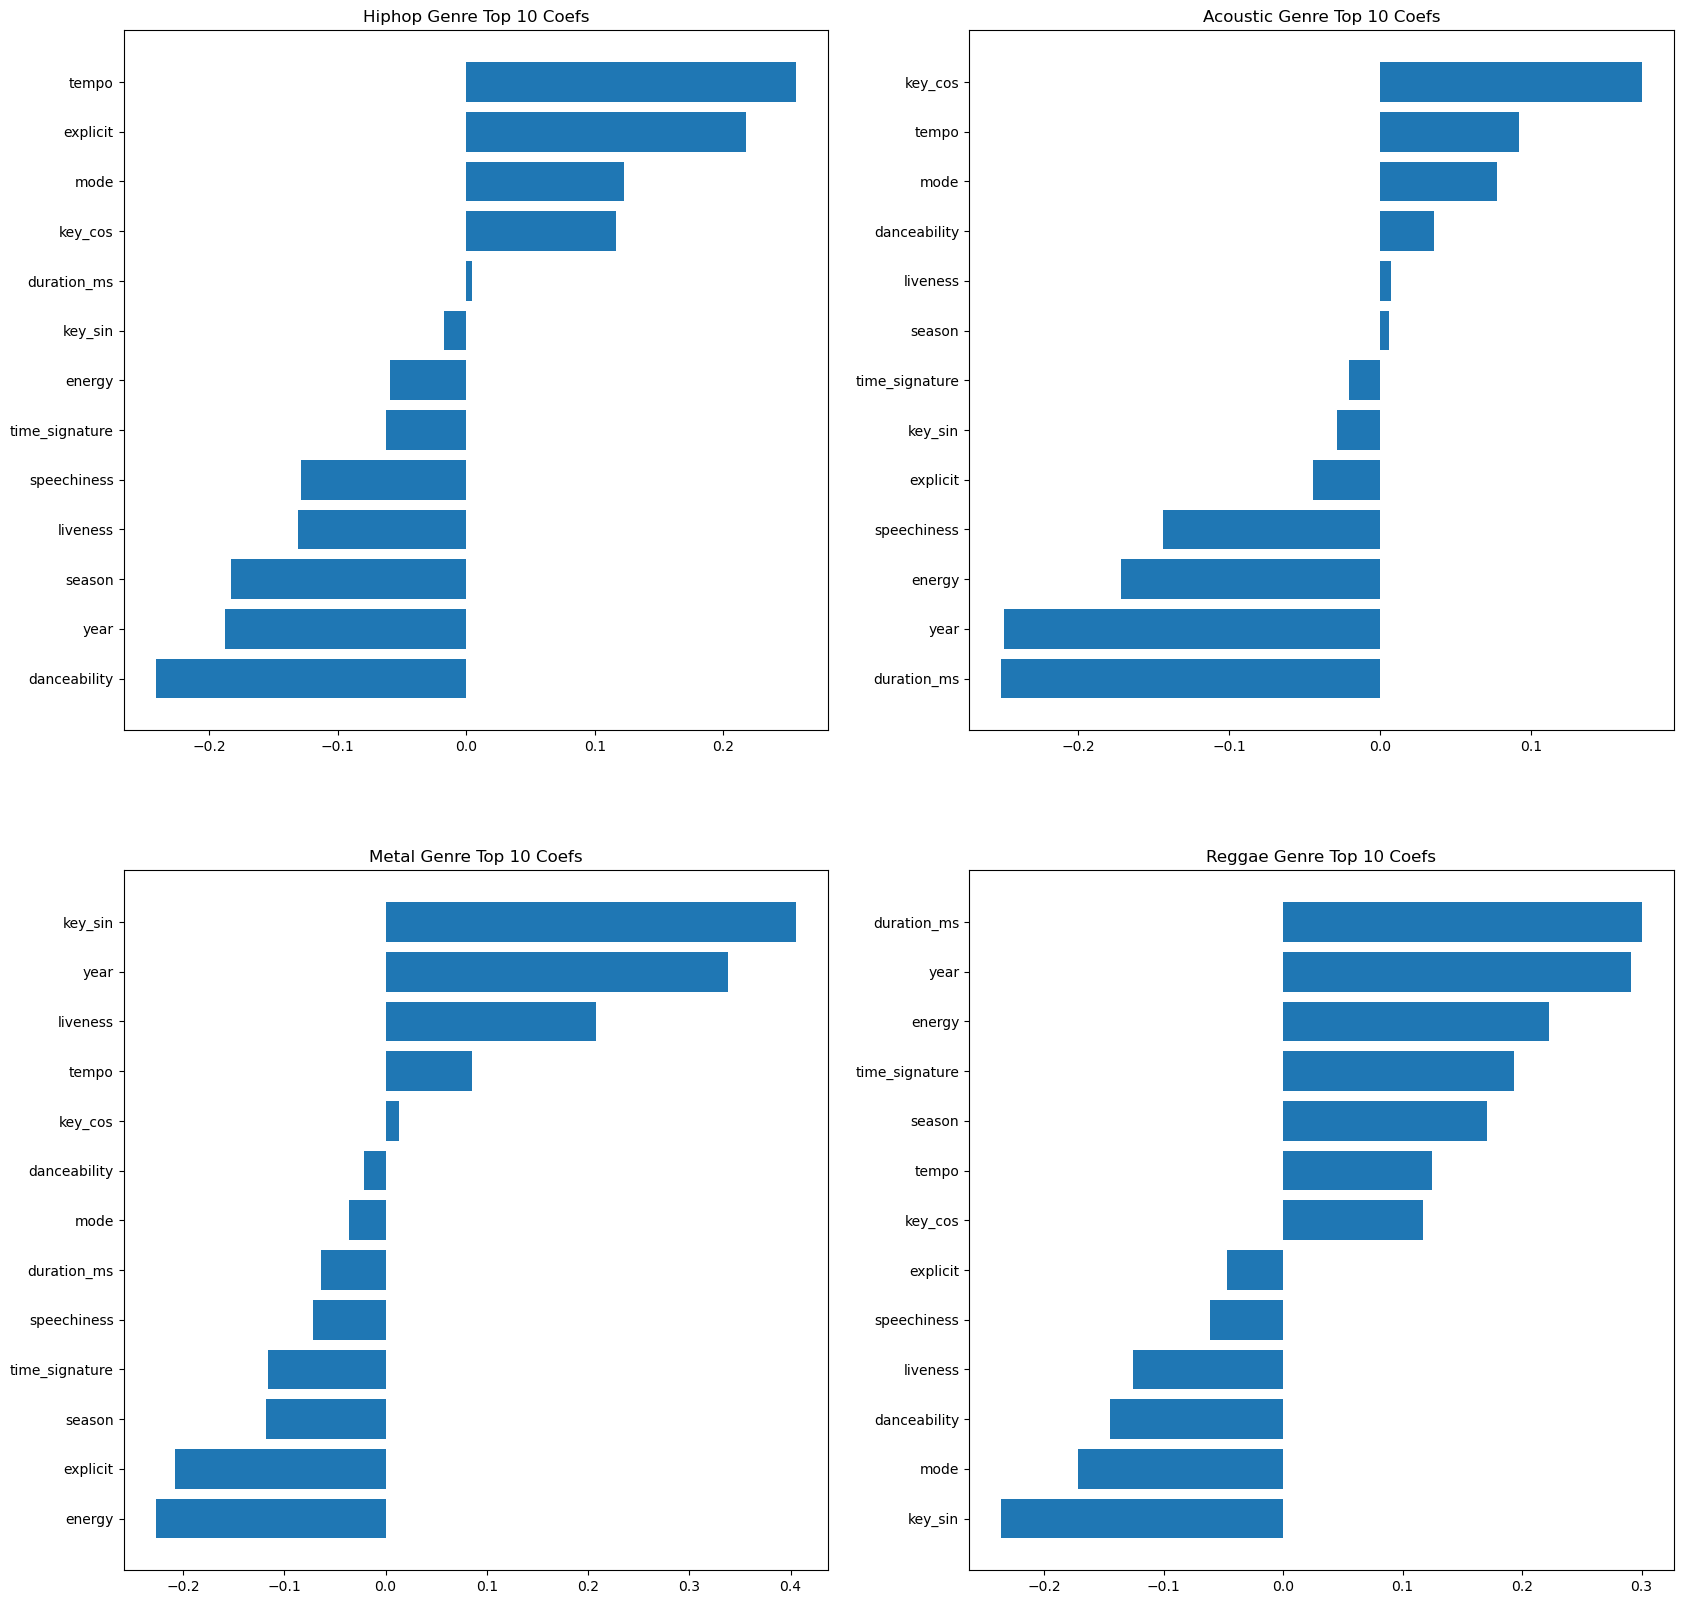

In [21]:
#plotting the coefs of each of the fours models
plt.subplots(2,2, figsize=(20,20))

plt.subplot(2,2,1)
plt.barh(hiphop_coefs.tail(10).sort_values(by='Coef')['Feature'],
         hiphop_coefs.tail(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.barh(hiphop_coefs.head(10).sort_values(by='Coef')['Feature'],
         hiphop_coefs.head(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.title('Hiphop Genre Top 10 Coefs')


plt.subplot(2,2,2)
plt.barh(acoustic_coefs.tail(10).sort_values(by='Coef')['Feature'],
         acoustic_coefs.tail(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.barh(acoustic_coefs.head(10).sort_values(by='Coef')['Feature'],
         acoustic_coefs.head(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.title('Acoustic Genre Top 10 Coefs')

plt.subplot(2,2,3)
plt.barh(metal_coefs.tail(10).sort_values(by='Coef')['Feature'],
         metal_coefs.tail(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.barh(metal_coefs.head(10).sort_values(by='Coef')['Feature'],
         metal_coefs.head(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.title('Metal Genre Top 10 Coefs')

plt.subplot(2,2,4)
plt.barh(reggae_coefs.tail(10).sort_values(by='Coef')['Feature'],
         reggae_coefs.tail(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.barh(reggae_coefs.head(10).sort_values(by='Coef')['Feature'],
         reggae_coefs.head(10).sort_values(by='Coef')['Coef'], color='#1f77b4')
plt.title('Reggae Genre Top 10 Coefs')


When fitting a model the same hyperparameters, but to a specific genre only, we see that the value of coefficients begin to change drastically. For example `explicit` was the greatest positive coefficient in the general model, but only remains as a positive coefficient in the hip-hop model. In the case of the three other genre specific models it switches into a negative coefficient. `tempo` seems to be important for popularity in all four genres even though that feature was no where to be found amongst the most influential coefficients of the general logit model. `year` was the second greatest negative coefficient of the general model, and remains that way for both Hip-hop and Acoustic tracks. However, in the case of metal and reggae, `year` moves to a positive coefficient. This means that older hip-hop and acoustic tracks are more popular, while newer metal and reggae tracks are more popular.

Essentially, the coefficient values of the general model differ greatly from models that are fit specifically to a genre. That much was expected, but the drastic nature of those coefficient changes is whats surprising.

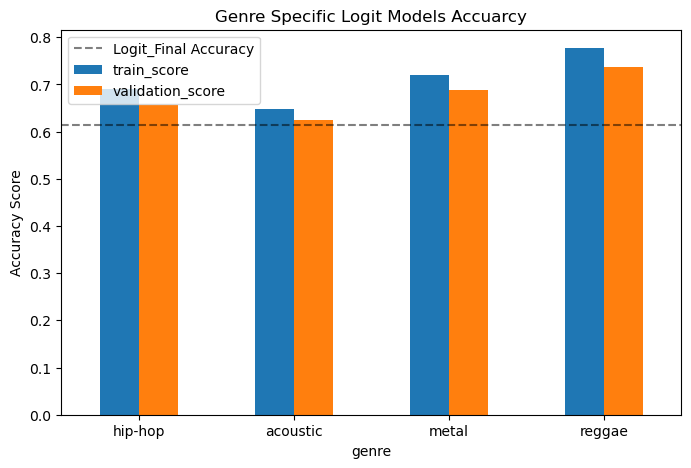

In [22]:
genre_logit_scores.plot(kind='bar',x='genre',figsize=(8,5))
plt.axhline( 0.615, label='Logit_Final Accuracy', linestyle='--', color='black', alpha=0.5)
plt.xticks(rotation=0)
plt.title('Genre Specific Logit Models Accuarcy')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

Overall, the four specified LogisticRegression models all achieve a higher accuracy score than the general model. This makes sense as the popularity of music is subjective and greatly based on taste, and a commonly agreed category for music taste is what a genre generally is. So when a model is only attempting to predict popularity for a single genre, it will likely yield more accurate results.

## RandomForest

The next model that we will be using is the RandomForest ensemble model. This model is a decision tree ensemble model, which means it runs multiple recursive decision trees in an attempt to fit a more effective model. 

### Gridsearches

In [23]:
#splitting into X and y
X_rem = df_remainder.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre','preview_url','popularity'])
y_rem = df_remainder['popularity']

In [24]:
# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])


# parameters
params = {
    'rf__max_depth':[5,10,15,None],
    'rf__n_estimators': [100],
    'rf__min_samples_leaf':[2,4,6,8,10],
    'rf__criterion': ['gini','entropy']
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('Gridsearches/RandomForest/RandomForest_grid_1.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [25]:
#the best parameters the gridsearch found
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': None,
 'rf__min_samples_leaf': 2,
 'rf__n_estimators': 100}

In [26]:
#the best score the gridsearch found
grid.best_score_

0.6697186982901269

In [27]:
#the top hyperparameter combinations for this model
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__max_depth,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
35,20.652220,0.128928,0.443973,0.007728,entropy,None,2,100,"{'rf__criterion': 'entropy', 'rf__max_depth': ...",0.665747,0.673911,0.677551,0.666409,0.664975,0.669719,0.005062,1
15,17.548055,0.128390,0.440189,0.003644,gini,None,2,100,"{'rf__criterion': 'gini', 'rf__max_depth': Non...",0.660563,0.674021,0.673138,0.667512,0.666078,0.668263,0.004931,2
36,18.124961,0.157298,0.385239,0.009313,entropy,None,4,100,"{'rf__criterion': 'entropy', 'rf__max_depth': ...",0.660232,0.675565,0.666520,0.666630,0.666299,0.667049,0.004899,3
16,15.338536,0.422789,0.377812,0.005183,gini,None,4,100,"{'rf__criterion': 'gini', 'rf__max_depth': Non...",0.653282,0.665306,0.668174,0.660783,0.660342,0.661577,0.005067,4
17,14.180512,0.202374,0.348943,0.002426,gini,None,6,100,"{'rf__criterion': 'gini', 'rf__max_depth': Non...",0.656591,0.662107,0.669939,0.661666,0.656371,0.661335,0.004937,5


In [28]:
# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])


# parameters
params = {
    'rf__n_estimators': [100],
    'rf__min_samples_leaf':[1,2,3],
    'rf__min_samples_split':[.25,.5,.75],
    'rf__criterion': ['gini','entropy']
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('Gridsearches/RandomForest/RandomForest_grid_2.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [29]:
#the best parameters the gridsearch found
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__min_samples_leaf': 3,
 'rf__min_samples_split': 0.25,
 'rf__n_estimators': 100}

In [30]:
#the best score the gridsearch found
grid.best_score_

0.5940650854936569

In [31]:
#the top hyperparameter combinations for this model
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__min_samples_leaf,param_rf__min_samples_split,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,4.651801,0.202454,0.155275,0.010407,entropy,3,0.25,100,"{'rf__criterion': 'entropy', 'rf__min_samples_...",0.590734,0.592940,0.595367,0.592940,0.598345,0.594065,0.002594,1
12,4.741336,0.165000,0.155360,0.001805,entropy,2,0.25,100,"{'rf__criterion': 'entropy', 'rf__min_samples_...",0.589851,0.594153,0.597022,0.592830,0.595918,0.593955,0.002506,2
0,4.063946,0.089461,0.133502,0.001867,gini,1,0.25,100,"{'rf__criterion': 'gini', 'rf__min_samples_lea...",0.591285,0.592278,0.595698,0.589961,0.597022,0.593249,0.002677,3
3,3.936726,0.099357,0.136553,0.002268,gini,2,0.25,100,"{'rf__criterion': 'gini', 'rf__min_samples_lea...",0.591506,0.592278,0.594374,0.591616,0.595808,0.593116,0.001696,4
6,4.030192,0.046461,0.157249,0.004077,gini,3,0.25,100,"{'rf__criterion': 'gini', 'rf__min_samples_lea...",0.589520,0.589851,0.593933,0.590623,0.595698,0.591925,0.002451,5


In [32]:
# estimator
estimator = Pipeline([
    ('rf', RandomForestClassifier())
])


# parameters
params = {
    'rf__n_estimators': [100],
    'rf__min_samples_leaf':[1,2,3],
    'rf__criterion': ['gini','entropy']
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('Gridsearches/RandomForest/RandomForest_grid_3.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [33]:
#the best parameters the gridsearch found
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 100}

In [34]:
#the best score the gridsearch found
grid.best_score_

0.6696525096525097

In [35]:
#the top hyperparameter combinations for this model
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__criterion,param_rf__min_samples_leaf,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,26.373136,0.436089,0.613596,0.008764,entropy,1,100,"{'rf__criterion': 'entropy', 'rf__min_samples_...",0.669498,0.667733,0.674242,0.671594,0.665196,0.669653,0.003111,1
5,17.731591,0.391331,0.317943,0.039775,entropy,3,100,"{'rf__criterion': 'entropy', 'rf__min_samples_...",0.664313,0.672146,0.675014,0.668395,0.665747,0.669123,0.003972,2
4,22.335534,1.640196,0.466506,0.087802,entropy,2,100,"{'rf__criterion': 'entropy', 'rf__min_samples_...",0.659901,0.673359,0.675676,0.668064,0.664534,0.668307,0.005741,3
0,26.473257,0.465138,0.921653,0.123882,gini,1,100,"{'rf__criterion': 'gini', 'rf__min_samples_lea...",0.660894,0.671263,0.668174,0.665527,0.666520,0.666475,0.003402,4
2,19.024656,0.422883,0.456700,0.011728,gini,3,100,"{'rf__criterion': 'gini', 'rf__min_samples_lea...",0.655929,0.672146,0.674021,0.665196,0.664644,0.666387,0.006407,5


### Best Model

In [36]:
df_train, df_validation = train_test_split(df_remainder, test_size=0.2, random_state=42, 
                                           stratify=df_remainder[['track_genre','popularity']])

df_train.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'track_genre','preview_url'],inplace=True)
df_validation.drop(columns=['track_id', 'artists', 'album_name', 'track_name', 'track_genre','preview_url'],inplace=True)

X_train = df_train.drop(columns='popularity')
y_train = df_train['popularity']
    
X_val = df_validation.drop(columns='popularity')
y_val = df_validation['popularity']

In [37]:
RF = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, criterion='entropy').fit(X_train,y_train)

In [38]:
y_pred_train = RF.predict(X_train)

print('Accuarcy Score: ',accuracy_score(y_pred_train,y_train))
print('recall Score: ',recall_score(y_pred_train,y_train))
print('f1 Score: ',f1_score(y_pred_train,y_train))
print('precision Score: ',precision_score(y_pred_train,y_train))

Accuarcy Score:  1.0
recall Score:  1.0
f1 Score:  1.0
precision Score:  1.0


In [39]:
y_pred_val = RF.predict(X_val)

print('Accuarcy Score: ',accuracy_score(y_pred_val,y_val))
print('recall Score: ',recall_score(y_pred_val,y_val))
print('f1 Score: ',f1_score(y_pred_val,y_val))
print('precision Score: ',precision_score(y_pred_val,y_val))

Accuarcy Score:  0.6773303916161059
recall Score:  0.6747038917089678
f1 Score:  0.6856528747984953
precision Score:  0.6969630762508193


## XGBoost

### Gridsearches

In [40]:
#splitting into X and y
X_rem = df_remainder.drop(columns=['track_id', 'album_name', 'artists', 'track_name', 'track_genre',
                                   'preview_url','popularity'])
y_rem = df_remainder['popularity']

In [41]:
# estimator
estimator = Pipeline([
    ('xgb', XGBClassifier())
])


# parameters
params = {
    'xgb__booster': ['gbtree','dart'],
    'xgb__learning_rate':[0.42,0.43,0.44],
    'xgb__n_estimators': [100,200],
    'xgb__gamma':[0.2],
    'xgb__subsample': [0.5]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('Gridsearches/XGBoost/XGBoost_grid_1.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [42]:
#the best parameters the gridsearch found
grid.best_params_

{'xgb__booster': 'gbtree',
 'xgb__gamma': 0.2,
 'xgb__learning_rate': 0.42,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.5}

In [43]:
#the best score the gridsearch found
grid.best_score_

0.893811362382791

In [44]:
#the top hyperparameter combinations for this model
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__booster,param_xgb__gamma,param_xgb__learning_rate,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,102.929858,0.350713,0.250449,0.035657,gbtree,0.2,0.42,200,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.888252,0.894650,0.892554,0.898952,0.894650,0.893811,0.003473,1
5,123.968467,0.181626,0.317292,0.031700,gbtree,0.2,0.44,200,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.885052,0.895753,0.891892,0.892113,0.893436,0.891649,0.003573,2
9,624.516945,6.342649,19.826617,0.852312,dart,0.2,0.43,200,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.893547,0.895422,0.887700,0.886707,0.891671,0.891009,0.003341,3
7,603.283437,4.593616,20.039887,0.196625,dart,0.2,0.42,200,0.5,"{'xgb__booster': 'dart', 'xgb__gamma': 0.2, 'x...",0.895532,0.891561,0.891340,0.889244,0.887259,0.890987,0.002759,4
3,104.919617,3.224885,0.221992,0.008652,gbtree,0.2,0.43,200,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.886045,0.892995,0.886045,0.887590,0.895532,0.889641,0.003899,5


In [45]:
# estimator
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier()
)])

# parameters
params = {
    'xgb__booster': ['gbtree'],
    'xgb__learning_rate':[0.2,0.4,0.6],
    'xgb__n_estimators': [50,75,100],
    'xgb__gamma':[0.2,0.25,0.3],
    'xgb__subsample': [0.5],
    'xgb__min_child_weight':[0.5, 1,5,10]
}



# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('Gridsearches/XGBoost/XGBoost_grid_2.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [46]:
#the best parameters the gridsearch found
grid.best_params_

{'xgb__booster': 'gbtree',
 'xgb__gamma': 0.25,
 'xgb__learning_rate': 0.4,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 100,
 'xgb__subsample': 0.5}

In [47]:
#the best score the gridsearch found
grid.best_score_

0.8783452840595697

In [48]:
#the top hyperparameter combinations for this model
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__booster,param_xgb__gamma,param_xgb__learning_rate,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
53,49.718121,0.030146,0.164026,0.006544,gbtree,0.25,0.4,1,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.874242,0.881853,0.876889,0.885383,0.873359,0.878345,0.004597,1
86,50.028678,0.169291,0.163386,0.006373,gbtree,0.3,0.4,0.5,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.3, ...",0.868395,0.867181,0.887259,0.883067,0.880750,0.877330,0.008075,2
89,49.703447,0.166600,0.160996,0.004109,gbtree,0.3,0.4,1,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.3, ...",0.864203,0.886045,0.877882,0.879868,0.877882,0.877176,0.007144,3
50,50.093948,0.181275,0.163336,0.011146,gbtree,0.25,0.4,0.5,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.871815,0.871484,0.878103,0.881191,0.881081,0.876735,0.004299,4
14,59.414940,1.643178,0.203993,0.016273,gbtree,0.2,0.4,0.5,100,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.2, ...",0.865968,0.882846,0.869498,0.875345,0.881412,0.875014,0.006552,5


In [49]:
# estimator
estimator = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier()
)])

# parameters
params = {
    'xgb__booster': ['gbtree'],
    'xgb__learning_rate':[0.3,0.4,0.5],
    'xgb__n_estimators': [70],
    'xgb__gamma':[0.23,0.25,0.27],
    'xgb__subsample': [0.5],
    'xgb__min_child_weight':[0.5, 0.75, 1]
}

# grid search
grid = GridSearchCV(estimator, param_grid=params, cv=5, n_jobs=-1, verbose=3)
grid.fit(X_rem, y_rem)

#writting to pickle
with open('Gridsearches/XGBoost/XGBoost_grid_3.pkl', "wb") as f:
    pickle.dump(grid, f)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [50]:
#the best parameters the gridsearch found
grid.best_params_

{'xgb__booster': 'gbtree',
 'xgb__gamma': 0.27,
 'xgb__learning_rate': 0.5,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 70,
 'xgb__subsample': 0.5}

In [51]:
#the best score the gridsearch found
grid.best_score_

0.8673579702151131

In [52]:
#the top hyperparameter combinations for this model
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__booster,param_xgb__gamma,param_xgb__learning_rate,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
26,32.714467,0.128123,0.118486,0.009130,gbtree,0.27,0.5,1,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.27,...",0.859459,0.857694,0.878764,0.868285,0.872587,0.867358,0.007926,1
17,36.131855,0.180548,0.153994,0.005765,gbtree,0.25,0.5,1,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.25,...",0.856040,0.860563,0.873249,0.869829,0.869277,0.865792,0.006427,2
8,36.241225,0.048454,0.185108,0.016963,gbtree,0.23,0.5,1,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.23,...",0.859680,0.866740,0.866409,0.869498,0.865747,0.865615,0.003232,3
22,35.789471,0.024658,0.153529,0.004794,gbtree,0.27,0.4,0.75,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.27,...",0.852068,0.864093,0.870050,0.865085,0.866078,0.863475,0.006051,4
24,36.034271,0.082944,0.154343,0.007443,gbtree,0.27,0.5,0.5,70,0.5,"{'xgb__booster': 'gbtree', 'xgb__gamma': 0.27,...",0.855929,0.864755,0.861886,0.864975,0.867512,0.863012,0.003964,5


### Best Model

In [53]:
 Final_XGB = XGBClassifier(booster='gbtree', gamma=0.27, learning_rate=0.5,
                          min_child_weight=1, n_estimators=70, subsample=0.5).fit(X_rem, y_rem)

In [54]:
y_pred_final_xg = Final_XGB.predict(X_rem)

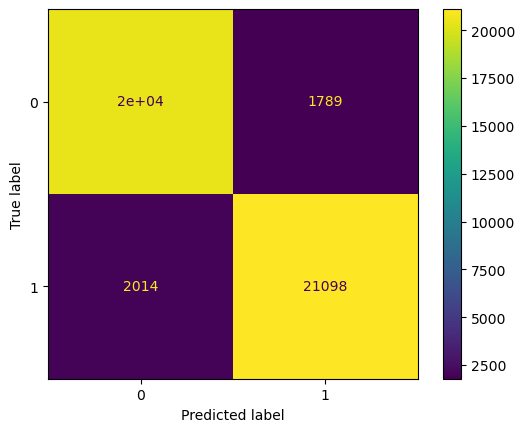

In [55]:
ConfusionMatrixDisplay(confusion_matrix(y_pred_final_xg,y_rem)).plot()

In [56]:
print('Accuarcy Score: ', accuracy_score(y_pred_final_xg,y_rem))
print('recall Score: ', precision_score(y_pred_final_xg,y_rem))
print('f1 Score: ', recall_score(y_pred_final_xg,y_rem))
print('precision Score: ', f1_score(y_pred_final_xg,y_rem))

Accuarcy Score:  0.9160948703805847
recall Score:  0.9218333551797964
f1 Score:  0.912859120803046
precision Score:  0.9173242896584707


## Conclusion to this Notebook